### Import TFRS

First, install and import TFRS:

In [15]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets



In [16]:

from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

### Read the data

In [3]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.ASF2D0_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.3CHBYB_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


In [4]:
print("Ratings Dataset:")
for rating in ratings.take(5):
    print(f"User ID: {rating['user_id'].numpy()}")
    print(f"Movie Title: {rating['movie_title'].numpy()}")
    print("---")



Ratings Dataset:
User ID: b'138'
Movie Title: b"One Flew Over the Cuckoo's Nest (1975)"
---
User ID: b'92'
Movie Title: b'Strictly Ballroom (1992)'
---
User ID: b'301'
Movie Title: b'Very Brady Sequel, A (1996)'
---
User ID: b'60'
Movie Title: b'Pulp Fiction (1994)'
---
User ID: b'197'
Movie Title: b'Scream 2 (1997)'
---


Build vocabularies to convert user ids and movie titles into integer indices for embedding layers:

In [5]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

### Define a model

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method:

In [22]:
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)
ratings = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train_size = int(0.8 * 100_000)
train = ratings.take(train_size)
test = ratings.skip(train_size).take(100_000 - train_size)


Define the two models and the retrieval task.

In [46]:
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 128),  # Embedding dimension
    tf.keras.layers.Reshape((1, 128)),  # Reshape to add the sequence dimension
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32)
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 128),  # Embedding dimension
    tf.keras.layers.Reshape((1, 128)),  # Reshape to add the sequence dimension
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
))


### Fit and evaluate it.

Create the model, train it, and generate predictions:



In [53]:
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))  # Adam optimizer

# Train for more epochs and store training history.
history1 = model.fit(
    train.batch(4096),
    validation_data=test.batch(4096),
    epochs=10
)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))


Epoch 1/10
20/20 [==============================] - 32s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0058 - factorized_top_k/top_10_categorical_accuracy: 0.0142 - factorized_top_k/top_50_categorical_accuracy: 0.0762 - factorized_top_k/top_100_categorical_accuracy: 0.1500 - loss: 31370.7523 - regularization_loss: 0.0000e+00 - total_loss: 31370.7523 - val_factorized_top_k/top_1_categorical_accuracy: 8.5000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0089 - val_factorized_top_k/top_10_categorical_accuracy: 0.0170 - val_factorized_top_k/top_50_categorical_accuracy: 0.0770 - val_factorized_top_k/top_100_categorical_accuracy: 0.1502 - val_loss: 28680.0430 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28680.0430
Epoch 2/10
20/20 [==============================] - 24s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.6250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0060 - factorized_top

In [54]:
# Get some recommendations for user with ID "42".
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :10]}")

Top 3 recommendations for user 42: [b'Romper Stomper (1992)' b'Killing Zoe (1994)' b'Speed (1994)'
 b'Copycat (1995)' b'Abyss, The (1989)' b'Malice (1993)'
 b'Mallrats (1995)' b'Cape Fear (1991)' b'Tombstone (1993)'
 b'Clear and Present Danger (1994)']


# 2nd **model**

In [38]:
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 128),  # Embedding dimension
    tf.keras.layers.Dense(64, activation='swish'),  # Added a dense layer
    tf.keras.layers.Dense(32, activation='swish')   # Another dense layer
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 128),  # Embedding dimension
    tf.keras.layers.Dense(64, activation='swish'),  # Added a dense layer
    tf.keras.layers.Dense(32, activation='swish')   # Another dense layer
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
))

In [39]:
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))  # Learning rate

# Train for more epochs and store training history.
history = model.fit(
    train.batch(4096),
    validation_data=test.batch(4096),
    epochs=10
)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

Epoch 1/10
20/20 [==============================] - 24s 969ms/step - factorized_top_k/top_1_categorical_accuracy: 2.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0286 - factorized_top_k/top_100_categorical_accuracy: 0.0580 - loss: 32417.5352 - regularization_loss: 0.0000e+00 - total_loss: 32417.5352 - val_factorized_top_k/top_1_categorical_accuracy: 3.5000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0026 - val_factorized_top_k/top_10_categorical_accuracy: 0.0058 - val_factorized_top_k/top_50_categorical_accuracy: 0.0309 - val_factorized_top_k/top_100_categorical_accuracy: 0.0580 - val_loss: 29626.4102 - val_regularization_loss: 0.0000e+00 - val_total_loss: 29626.4102
Epoch 2/10
20/20 [==============================] - 24s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_

In [40]:
# Get some recommendations for user with ID "42".
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :10]}")

Top 3 recommendations for user 42: [b'Baby-Sitters Club, The (1995)' b'Swan Princess, The (1994)'
 b'Striking Distance (1993)' b'Rent-a-Kid (1995)' b'Tom and Huck (1995)'
 b'Little Rascals, The (1994)' b"Kid in King Arthur's Court, A (1995)"
 b'Love Affair (1994)' b'For Love or Money (1993)' b'Amos & Andrew (1993)']


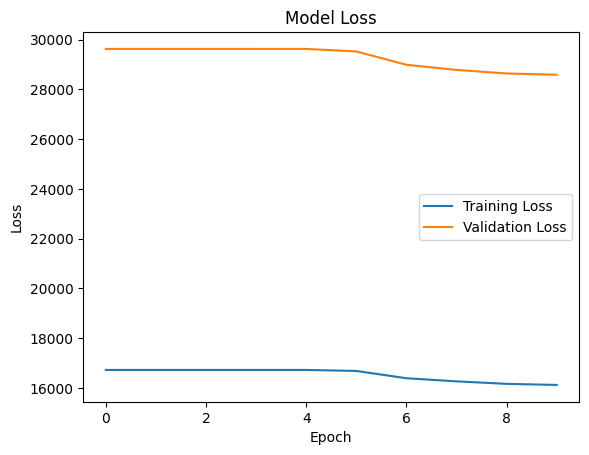

In [43]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d120>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d120>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e950>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e950>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ed40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ed40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e8c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e8c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ed40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ed40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2cf70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2cf70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e8c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e8c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f010>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f010>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e950>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Top-10 Accuracy: 3.85%
Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e950>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f400>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f400>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f2e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f2e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f400>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f400>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c940>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e9e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e9e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f2e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f2e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f2e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f2e0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ee60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ee60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ee60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ee60>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f9a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f9a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f9a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f9a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e7a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f9a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f9a0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ef80>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f640>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f130>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f130>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f130>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f130>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fe20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fe20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fe20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fe20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e3b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e3b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f1c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f1c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f1c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f1c0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e3b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e3b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f910>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e3b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2e3b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2feb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2feb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fc70>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2feb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2feb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fbe0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fbe0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2feb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2feb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ff40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ff40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fd90>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fd90>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ff40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ff40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fd90>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fd90>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fe20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fe20>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fd90>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fd90>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2d900>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f6d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2edd0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2edd0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2edd0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2edd0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2ecb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f880>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2c700>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fb50>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fb50>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2f5b0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function compute_top_k_accuracy.<locals>.<lambda> at 0x7839a0f2fa30>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: x['movie_title']

Match 1:
lambda x: x['user_id'] == user

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


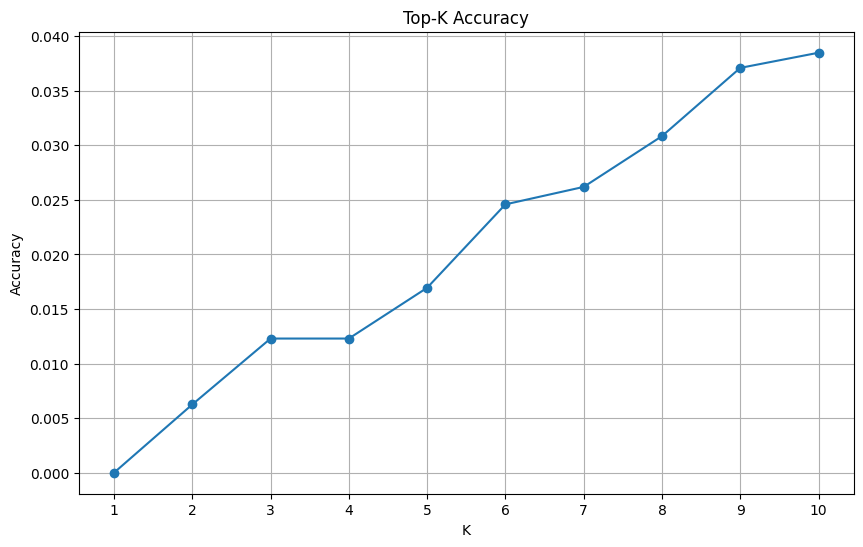

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Compute Top-K accuracy
def compute_top_k_accuracy(index, users, k=10):
    top_k_accuracies = []
    for user in users:
        _, titles = index(np.array([user]))
        correct_titles_ds = train.filter(lambda x: x['user_id'] == user).map(lambda x: x['movie_title'])
        correct_titles = [x.numpy().decode('utf-8') for x in list(correct_titles_ds)]
        recommended_titles = [title.numpy().decode('utf-8') for title in titles[0, :k]]

        accuracy = len(set(recommended_titles) & set(correct_titles)) / len(correct_titles) if correct_titles else 0
        top_k_accuracies.append(accuracy)

    return np.mean(top_k_accuracies)

# Sample users
sample_users = ["42", "43", "44", "45", "46"]
top_k_accuracy = compute_top_k_accuracy(index, sample_users, k=10)

print(f"Top-10 Accuracy: {top_k_accuracy * 100:.2f}%")

# Plot Top-K Accuracy
k_values = range(1, 11)
accuracies = [compute_top_k_accuracy(index, sample_users, k) for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Top-K Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

